In [1]:
%pip install xgboost
%pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Marc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Marc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler


from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

Dataset

In [3]:
data = pd.read_csv("car.data.csv")

In [4]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,quality
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
# Encode categorical variables using Label Encoding
label_encoder = LabelEncoder()
categorical_cols = ['buying', 'maint', 'lug_boot', 'safety']
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [6]:
data.replace("5more", 5, inplace=True)
data.replace("more", 5, inplace=True)

In [7]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,quality
0,3,3,2,2,2,1,unacc
1,3,3,2,2,2,2,unacc
2,3,3,2,2,2,0,unacc
3,3,3,2,2,1,1,unacc
4,3,3,2,2,1,2,unacc


In [8]:
X = data.drop("quality", axis=1)
y = data["quality"]

label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
xgboost_model = XGBClassifier(objective='multi:softmax', num_class=len(label_mapping))
xgboost_model.fit(X_train, y_train, verbose = 5)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [12]:
catboost_model = CatBoostClassifier(iterations = 150 , depth = 5, learning_rate = 0.3 , loss_function='MultiClass')
catboost_model.fit(X_train, y_train, verbose = 15)

0:	learn: 1.0656403	total: 145ms	remaining: 21.7s
15:	learn: 0.2187014	total: 270ms	remaining: 2.26s
30:	learn: 0.1216388	total: 306ms	remaining: 1.18s
45:	learn: 0.0836041	total: 340ms	remaining: 769ms
60:	learn: 0.0613959	total: 376ms	remaining: 548ms
75:	learn: 0.0468600	total: 421ms	remaining: 410ms
90:	learn: 0.0392031	total: 455ms	remaining: 295ms
105:	learn: 0.0321159	total: 490ms	remaining: 203ms
120:	learn: 0.0272209	total: 520ms	remaining: 125ms
135:	learn: 0.0235938	total: 559ms	remaining: 57.5ms
149:	learn: 0.0209672	total: 596ms	remaining: 0us


In [13]:
y_pred1 = xgboost_model.predict(X_test)

In [14]:
y_pred2 = catboost_model.predict(X_test)

In [15]:
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy (XGBoost): {accuracy1 * 100:.2f}%")

Accuracy (XGBoost): 97.98%


In [16]:
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy (CatBoost): {accuracy1 * 100:.2f}%")

Accuracy (CatBoost): 97.98%


In [17]:
conf_matrix1 = confusion_matrix(y_test, y_pred1)

In [18]:
conf_matrix2 = confusion_matrix(y_test, y_pred2)

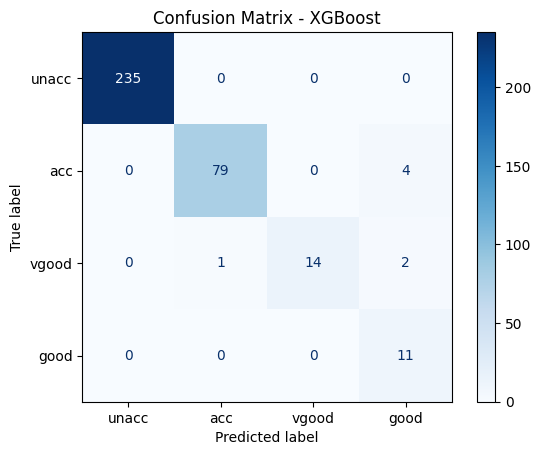

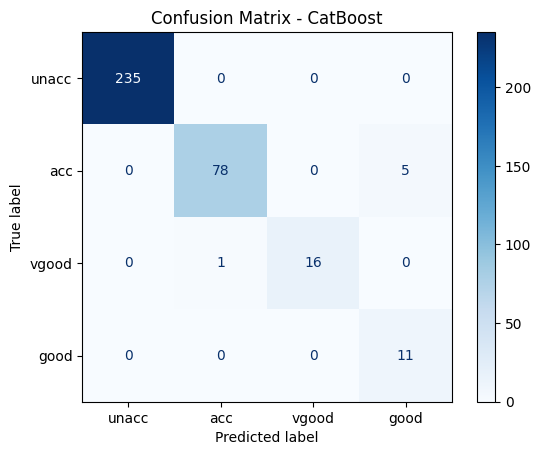

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix1, display_labels=label_mapping.keys())
disp.plot(cmap="Blues", values_format="d")
plt.title('Confusion Matrix - XGBoost')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2, display_labels=label_mapping.keys())
disp.plot(cmap="Blues", values_format="d")
plt.title('Confusion Matrix - CatBoost')
plt.show()

In [20]:
y_test_bin1 = label_binarize(y_test, classes=list(label_mapping.values()))
y_pred_prob1 = xgboost_model.predict_proba(X_test)

y_test_bin2 = label_binarize(y_test, classes=list(label_mapping.values()))
y_pred_prob2 = catboost_model.predict_proba(X_test)

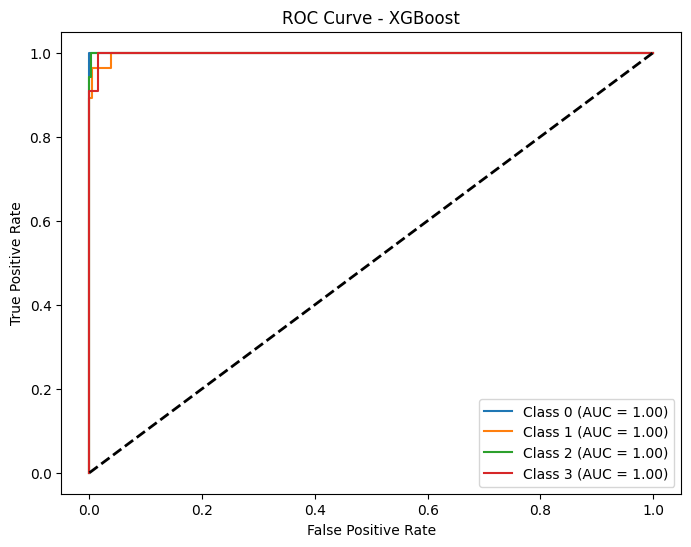

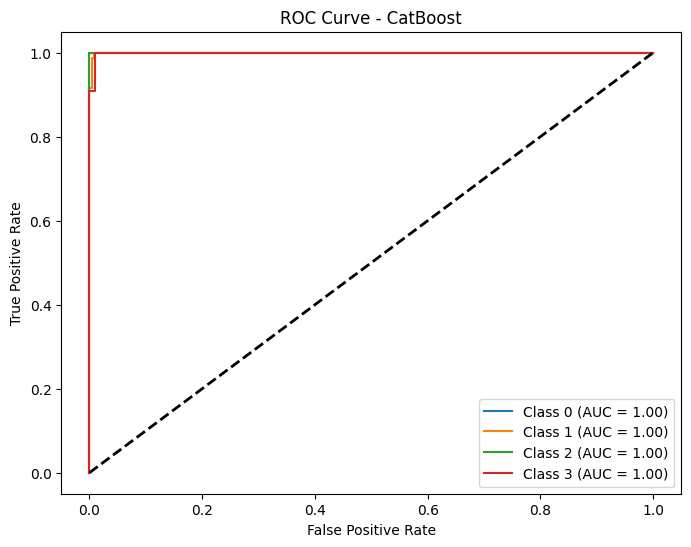

In [21]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(xgboost_model.classes_.shape[0]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin1[:, i], y_pred_prob1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(8, 6))

for i in range(xgboost_model.classes_.shape[0]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(catboost_model.classes_.shape[0]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin2[:, i], y_pred_prob2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(8, 6))

for i in range(catboost_model.classes_.shape[0]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc='lower right')
plt.show()

In [22]:
classification_rep_xgboost = classification_report(y_test, y_pred1, digits=4)
classification_rep_catboost = classification_report(y_test, y_pred2, digits=4)

print("Classification Report (XGBoost):")
print(classification_rep_xgboost)
print()
print("Classification Report (CatBoost):")
print(classification_rep_catboost)

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       235
           1     0.9875    0.9518    0.9693        83
           2     1.0000    0.8235    0.9032        17
           3     0.6471    1.0000    0.7857        11

    accuracy                         0.9798       346
   macro avg     0.9086    0.9438    0.9146       346
weighted avg     0.9858    0.9798    0.9811       346


Classification Report (CatBoost):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       235
           1     0.9873    0.9398    0.9630        83
           2     1.0000    0.9412    0.9697        17
           3     0.6875    1.0000    0.8148        11

    accuracy                         0.9827       346
   macro avg     0.9187    0.9702    0.9369       346
weighted avg     0.9870    0.9827    0.9837       346

